# **ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА**

#### HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

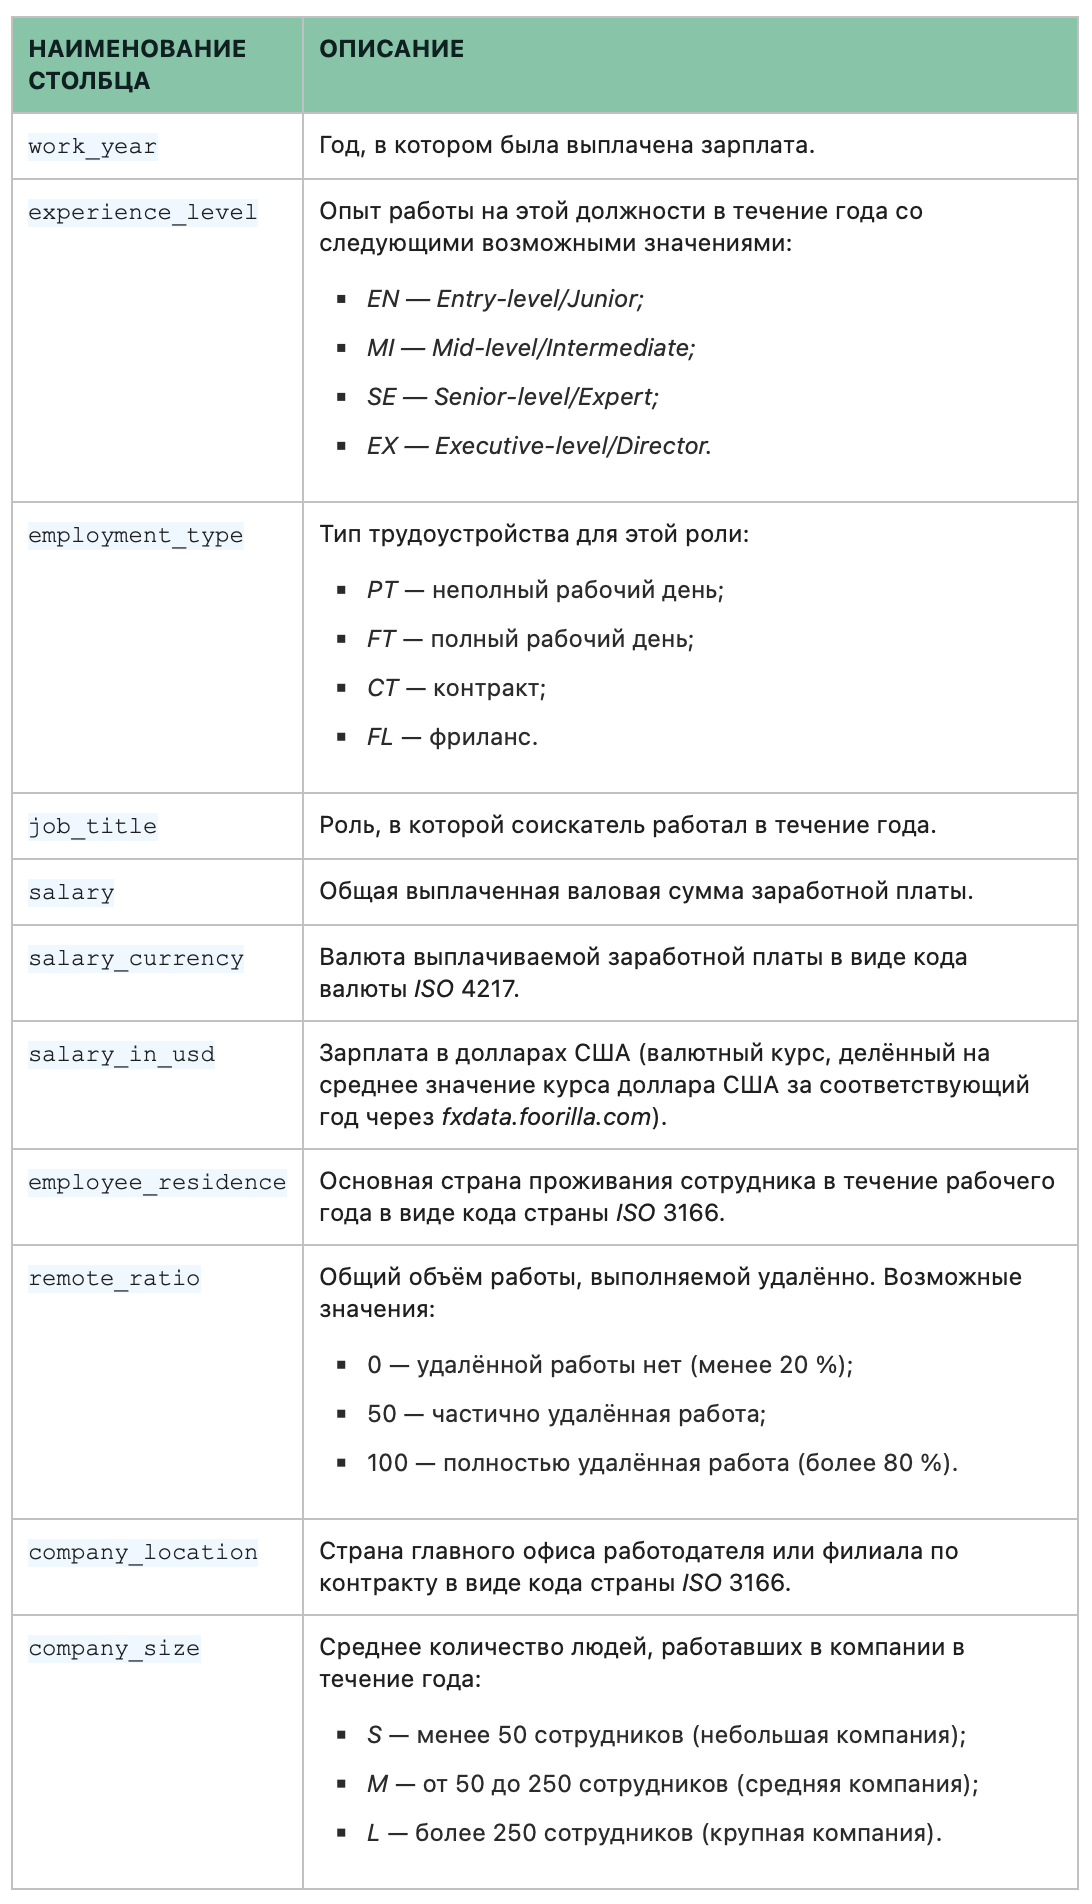

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

* тесты для количественного признака:
    * для одной выборки;
    * для двух выборок;
    * для нескольких выборок;

* тест для категориальных признаков.

In [7]:
import pandas as pd
from IPython.display import Markdown
import plotly.express as px
import plotly.io as pio
from scipy import stats
import numpy as np
from pycountry_convert import country_alpha2_to_country_name
from statsmodels.stats.descriptivestats import sign_test

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'

## **Загрузка и обработка данных**

In [8]:
# Знакомсво с данными
df = pd.read_csv('data/ds_salaries.csv', index_col=0)
display(Markdown('### Просматриваем набор данных')),
display(df.sample(5)),
display(Markdown('### Характеристики категориальных столбцов')),
display(df.describe(include=object).T),
display(Markdown('### Характеристики числовых столбцов')),
display(df.describe().T)
display(Markdown('### Характеристики столбцов')),
df.info(),
print('\n')
print('Количество дубликатов:', df.duplicated().sum(), '\n')
print('Количество пропусков:', df.isna().sum().sum(), '\n')
nums_list_col = [col for col in df.columns if df[col].dtype != object]
cat_list_col = [col for col in df.columns if df[col].dtype == object]
print(f'Количество числовых столбцов: {len(nums_list_col)}\n{nums_list_col}\n')
print(f'Количество категориальных столбцов: {len(cat_list_col)}\n{cat_list_col}')

### Просматриваем набор данных

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
246,2021,EN,FT,Data Scientist,31000,EUR,36643,FR,50,FR,L
347,2022,SE,FT,Data Scientist,95550,USD,95550,US,0,US,M
295,2022,MI,FT,Data Engineer,150000,USD,150000,US,100,US,M
568,2022,SE,FT,Data Analyst,80000,USD,80000,US,100,US,M
179,2021,MI,FT,Data Scientist,420000,INR,5679,IN,100,US,S


### Характеристики категориальных столбцов

,count,unique,top,freq
experience_level,607,4,SE,280
employment_type,607,4,FT,588
job_title,607,50,Data Scientist,143
salary_currency,607,17,USD,398
employee_residence,607,57,US,332
company_location,607,50,US,355
company_size,607,3,M,326


### Характеристики числовых столбцов

,count,mean,std,min,25%,50%,75%,max
work_year,607.0,2021.405272,6.921330e-01,2020.0,2021.0,2022.0,2022.0,2022.0
salary,607.0,324000.062603,1.544357e+06,4000.0,70000.0,115000.0,165000.0,30400000.0
salary_in_usd,607.0,112297.869852,7.095726e+04,2859.0,62726.0,101570.0,150000.0,600000.0
remote_ratio,607.0,70.922570,4.070913e+01,0.0,50.0,100.0,100.0,100.0


### Характеристики столбцов

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


Количество дубликатов: 42 

Количество пропусков: 0 

Количество числовых столбцов: 4
['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

Количество категориальных столбцов: 7
['experience_level', 'employment_type', '

### Удаляем дубликаты

In [9]:
df.drop_duplicates(inplace=True)
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


### Удаляем не информативные признаки

К неинформативным признакам относятся ``salary``, ``salary_currency`` так как у нас уже есть признак ``salary_in_usd``, который является общим и где все зарплаты приведены к единому масштабу **USD**.

In [10]:
df.drop(columns=['salary', 'salary_currency'], inplace=True)

### Закодируем признаки 

* В столбце ``remote_ratio`` заменим **0**, **50** и **100** на '**Не удаленная**' '**Частично удаленная**' '**Полностью удаленная**'
* В столбце ``experience_level`` заменим абривиатуры на более понятные значения **EN - Junior**, **MI - Middle**, **SE - Senior**, **EX - Director**
* В столбце ``employment_type`` заменим абривиатуры **PT - Неполный рабочий день**, **FT - Полный рабочий день**, **CT — Контракт**, **FL — Фриланс**
* В столбцк ``company_size`` заменим **S**, **M**, **L**, на **Небольшая компания**, **Cредняя компания**, **Крупная компания**

In [11]:
# Функция для перевода значений в читабельный вид в столбце remote_ratio
def remote_ratio(remote_ratio):
    if remote_ratio == 0:
        return 'Не удаленная'
    elif remote_ratio == 50:
        return 'Частично удаленная'
    else:
        return 'Удаленная'
# Функция для перевода значений в читабельный вид в столбце experience_level
def experience_level(experience_level):
    if experience_level == 'EN':
        return 'Junior'
    elif experience_level == 'MI':
        return 'Middle'
    elif experience_level == 'SE':
        return 'Senior'
    else:
        return 'Director'
# Функция для перевода значений в читабельный вид в столбце employment_type 
def employment_type(employment_type):
    if employment_type == 'PT':
        return 'Неполный рабочий день'
    elif employment_type == 'FT':
        return 'Полный рабочий день'
    elif employment_type == 'CT':
        return 'Контракт'
    else:
        return 'Фриланс'
# Функция для перевода значений в читабельный вид в столбце company_size    
def company_size(company_size):
    if company_size == 'S':
        return 'Небольшая компания'
    elif company_size == 'M':
        return 'Cредняя компания'
    else:
        return 'Крупная компания'

df['remote_ratio'] = df['remote_ratio'].apply(remote_ratio)
df['experience_level'] = df['experience_level'].apply(experience_level)
df['employment_type'] = df['employment_type'].apply(employment_type)
df['company_size'] = df['company_size'].apply(company_size)

## Разведывательный анализ данных




### Визуальный анализ всех данных

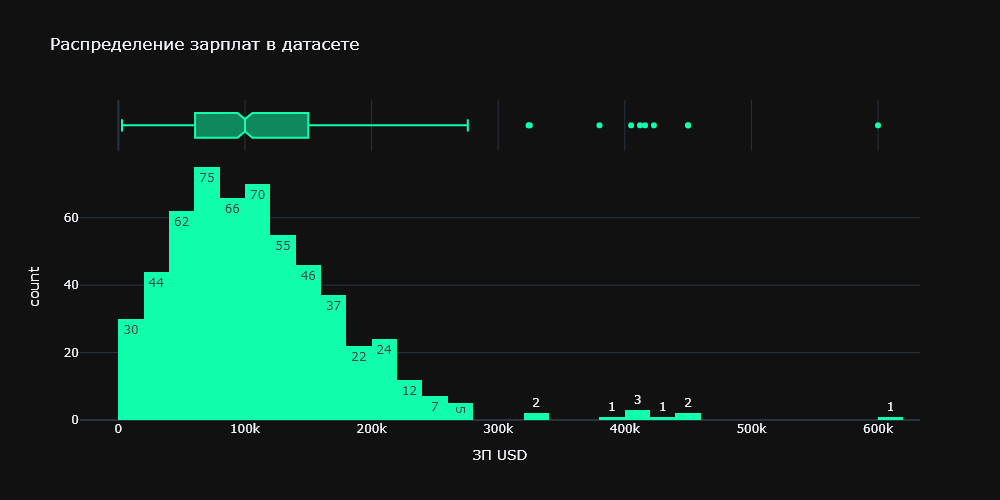

In [12]:
fig = px.histogram(
    df,
    x='salary_in_usd',
    title='Распределение зарплат в датасете',
    width=1000,
    height=500,
    color_discrete_sequence=['#11ffac'],
    text_auto=True,
    marginal='box',
    labels={'salary_in_usd': 'ЗП USD'},
)
fig

По графику видно, что распределение зарплат близко к нормальному Построим границы $(\mu - 3\sigma)$ и $(\mu + 3\sigma)$. (метод трёх сигм для нормального распределения):

Прологарифмируем признак, что бы привести его к нормальному распределению:

* Белая линия обозначает среднее $\mu$
* Красные пунктирные линии обозначают $\mu \pm 3\sigma$
* Красная область считаться выбросами.

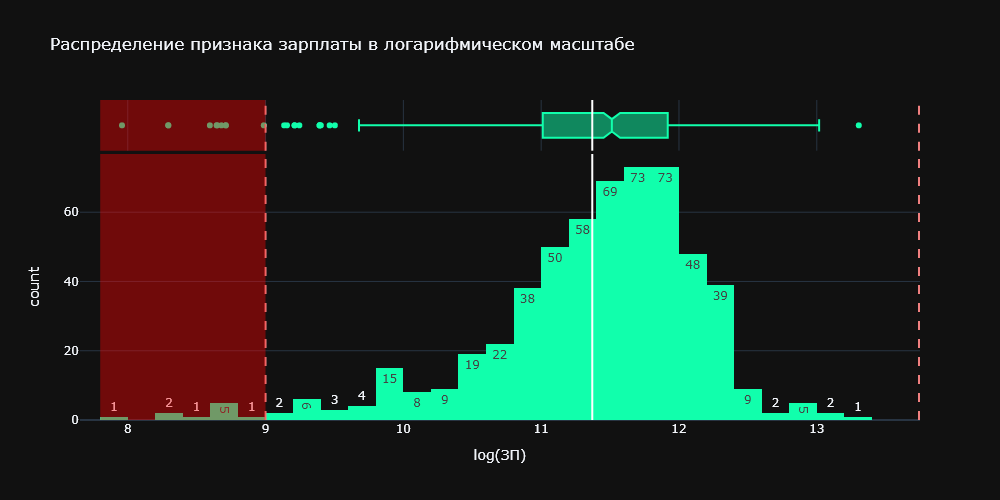

In [13]:
df['salary_log'] = np.log(df['salary_in_usd'])

fig = px.histogram(
    df,
    x='salary_log',
    title=f'Распределение признака зарплаты в логарифмическом масштабе',
    width=1000,
    height=500,
    color_discrete_sequence=['#11ffac'],
    text_auto=True,
    marginal='box',
    labels={'salary_log': 'log(ЗП)'},
).add_vline(
    x=df['salary_log'].mean() - 3*df['salary_log'].std(),
    line_dash='dash',
    line_color='#F08080'
).add_vline(
    x=df['salary_log'].mean() + 3*df['salary_log'].std(),
    line_dash='dash',
    line_color='#F08080'
).add_vrect(
    x0=7.8,
    x1=df['salary_log'].mean() - 3*df['salary_log'].std(),
    fillcolor='#ff0000',
    line_width=0,
    opacity=0.4
).add_vline(
    x=df['salary_log'].mean(),
    line_color='#fff'
)
fig

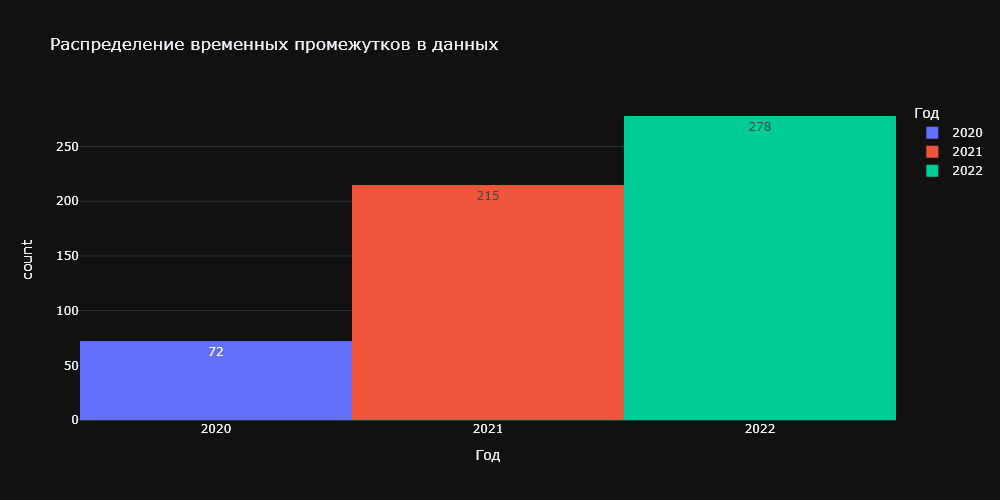

In [14]:
px.histogram(
    df,
    title='Распределение временных промежутков в данных',
    x='work_year',
    text_auto=True,
    height=500,
    width=1000,
    color='work_year',
    labels={'work_year': 'Год'},
    nbins=3,
).update_xaxes(tickmode='array', tickvals=[2020, 2021, 2022])

По графику видно, что в датасете преобладют данные за 2021 и 2022 год.

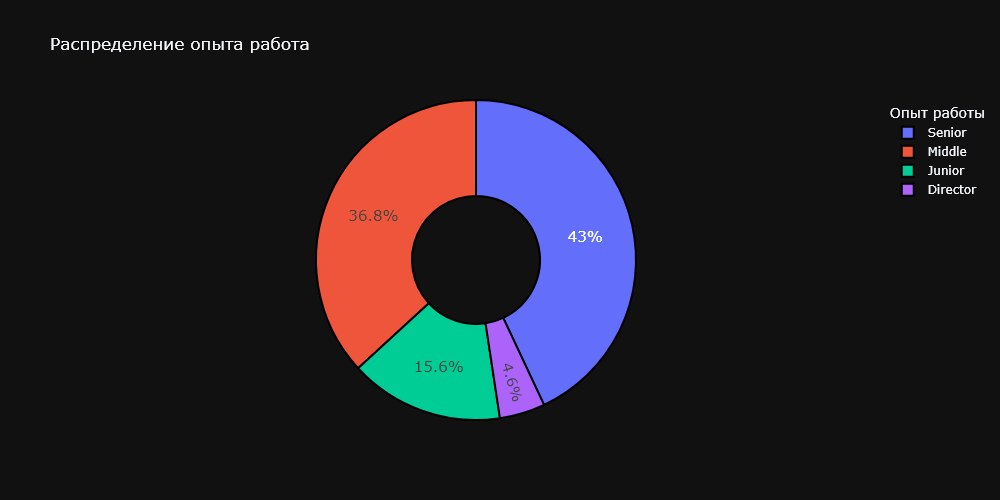

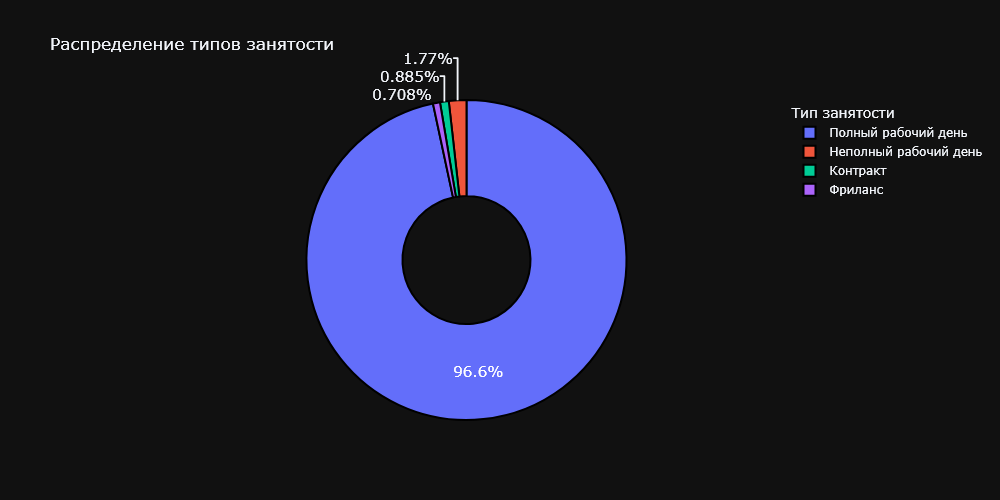

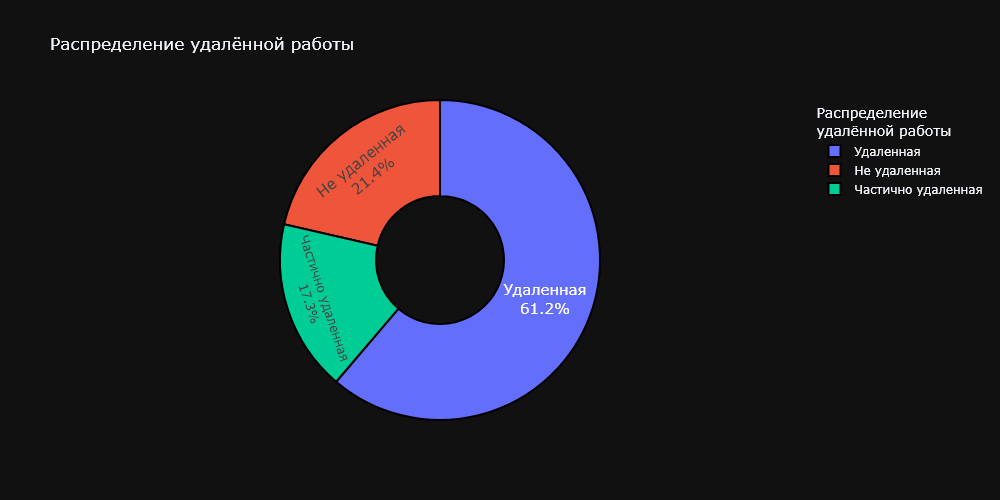

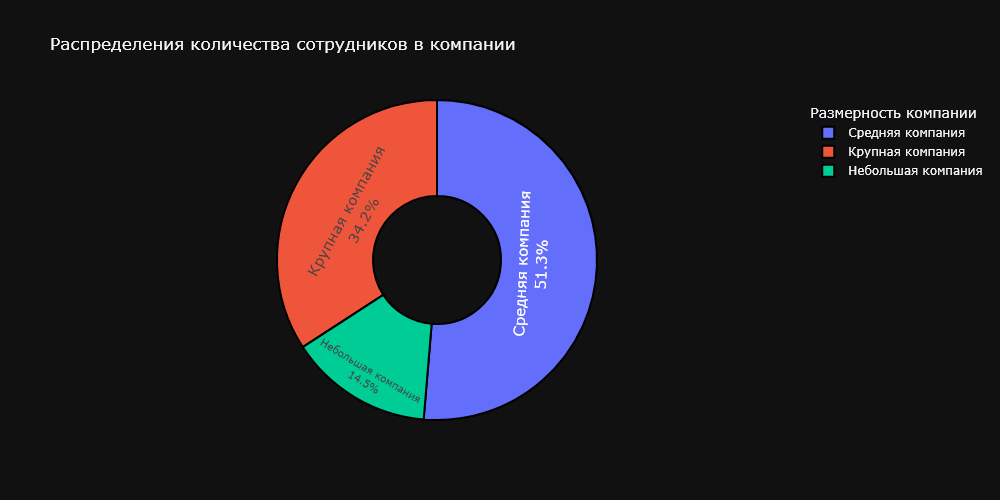

In [15]:
fig_1 = px.pie(
    df,
    title='Распределение опыта работа',
    names='experience_level',
    width=1000,
    height=500,
    hole=0.4,
).update_layout(
    legend=dict(title="Опыт работы")
).update_traces(
    textfont_size=15, 
    marker=dict(line=dict(color='#000', width=2))
)
fig_2 = px.pie(
    df,
    title='Распределение типов занятости',
    names='employment_type',
    width=1000,
    height=500,
    hole=0.4,
).update_layout(
    legend=dict(title="Тип занятости")
).update_traces(
    textfont_size=15, 
    marker=dict(line=dict(color='#000', width=2))
)
fig_3 = px.pie(
    df,
    names='remote_ratio',
    width=1000,
    height=500,
    title='Распределение удалённой работы',
    hole=0.4
).update_traces(
    textinfo='percent+label',
    textfont_size=15,
    textposition='inside',
    marker=dict(line=dict(color='#000', width=2))
).update_layout(
    legend=dict(title="Распределение<br>удалённой работы"),
)
fig_4 = px.pie(
    df,
    names='company_size',
    width=1000,
    height=500,
    title='Распределения количества сотрудников в компании',
    hole=0.4
).update_traces(
    textinfo='percent+label',
    textposition='inside',
    textfont_size=15,
    marker=dict(line=dict(color='#000', width=2))
).update_layout(
    legend=dict(title="Размерность компании")
)

display(fig_1),
display(fig_2),
display(fig_3),
display(fig_4)

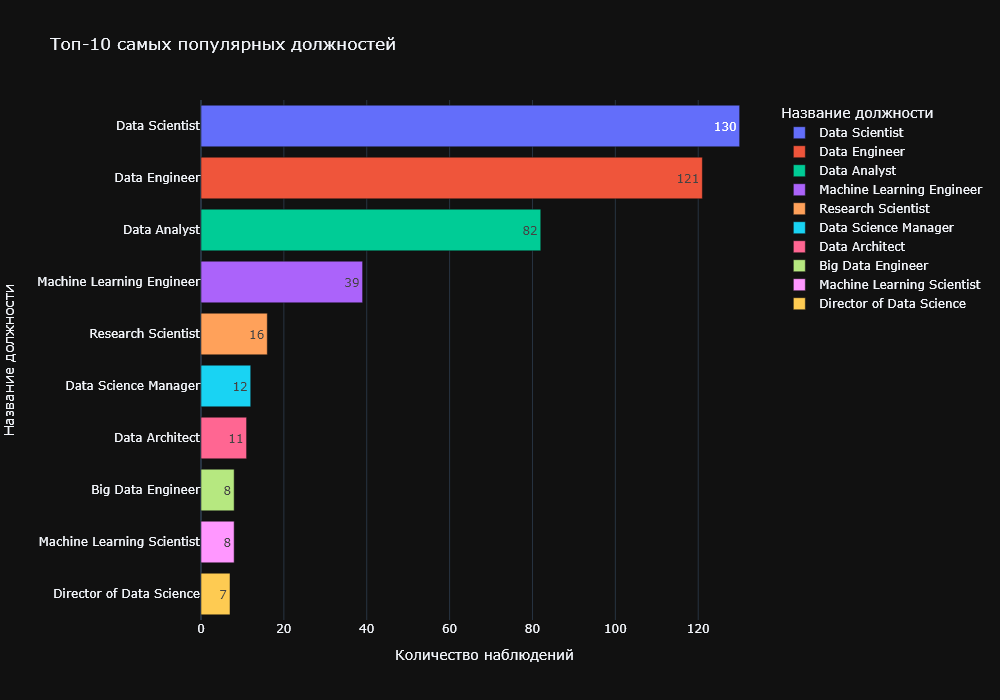

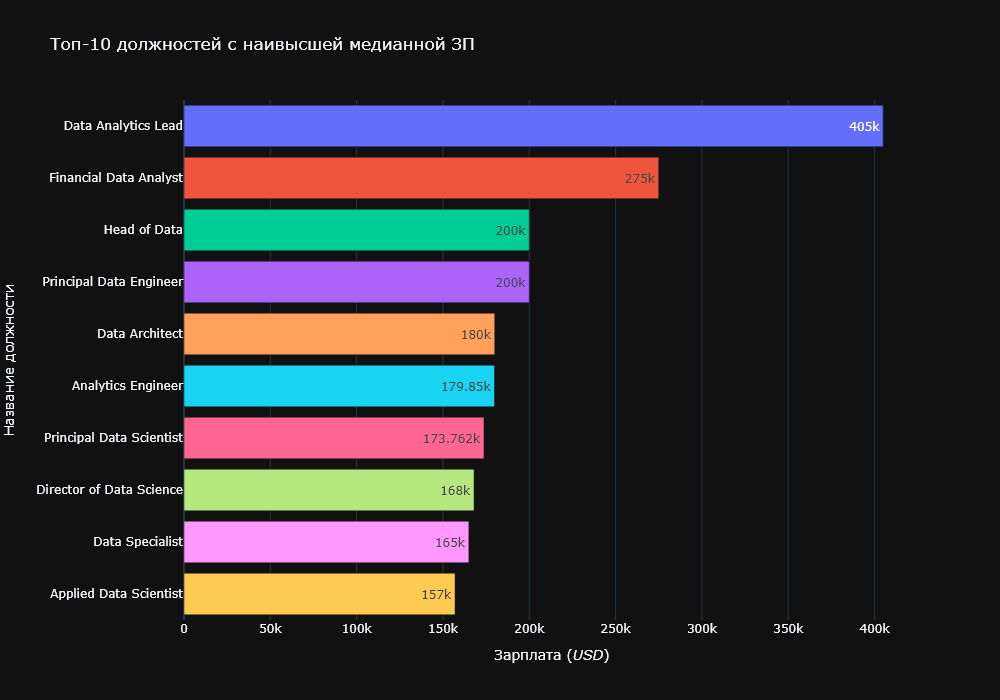

In [16]:
grouped_job = df.groupby(by='job_title', as_index=False)['salary_in_usd'].count().rename(columns={'salary_in_usd': 'count'}).sort_values(by='count',ascending=False).head(10)

fig_1 = px.bar(
    data_frame=grouped_job,
    y='job_title',
    x='count',
    title='Топ-10 самых популярных должностей',
    width=1000,
    height=700,
    color='job_title',
    text_auto=True,
    labels={'count': 'Количество наблюдений', 'job_title': 'Название должности'}
)

grouped_job_salary = df.groupby(by='job_title', as_index=False)['salary_in_usd'].median().sort_values(by='salary_in_usd',ascending=False).head(10)

fig_2 = px.bar(
    grouped_job_salary,
    y='job_title',
    x='salary_in_usd',
    width=1000,
    height=700,
    title='Топ-10 должностей с наивысшей медианной ЗП',
    color='job_title',
    labels={
        'job_title': 'Название должности',
        'salary_in_usd': 'Зарплата (<i>USD</i>)'
    },
    text_auto=True
).update_layout(showlegend=False)

display(fig_1),
display(fig_2)

Конвертируем столбцы со странами из формата ISO 3166-2 в названия стран для удобства визуализации.

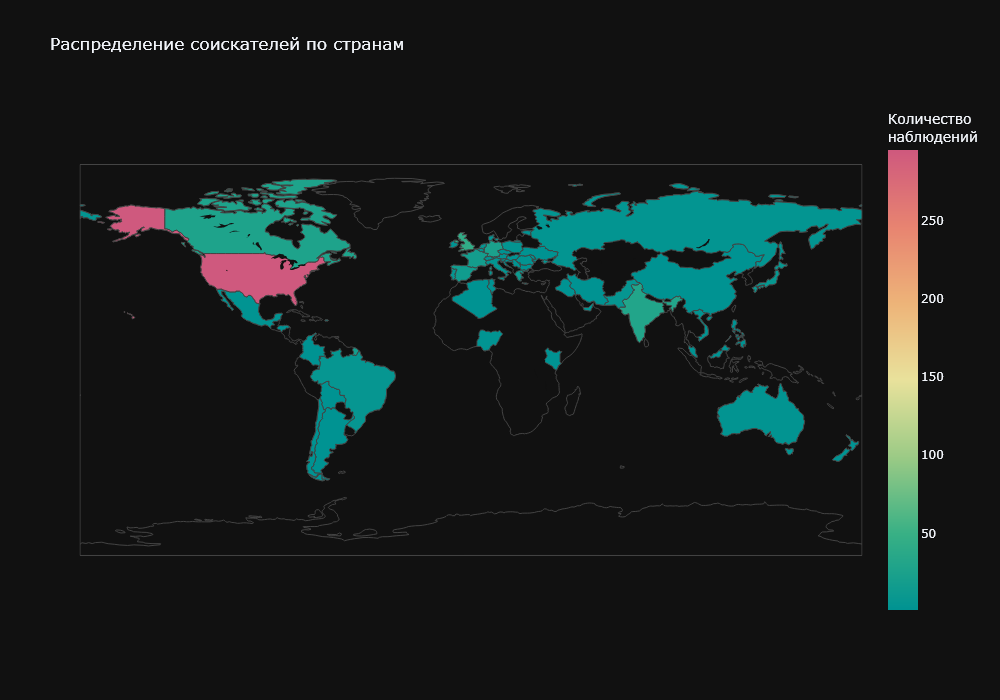

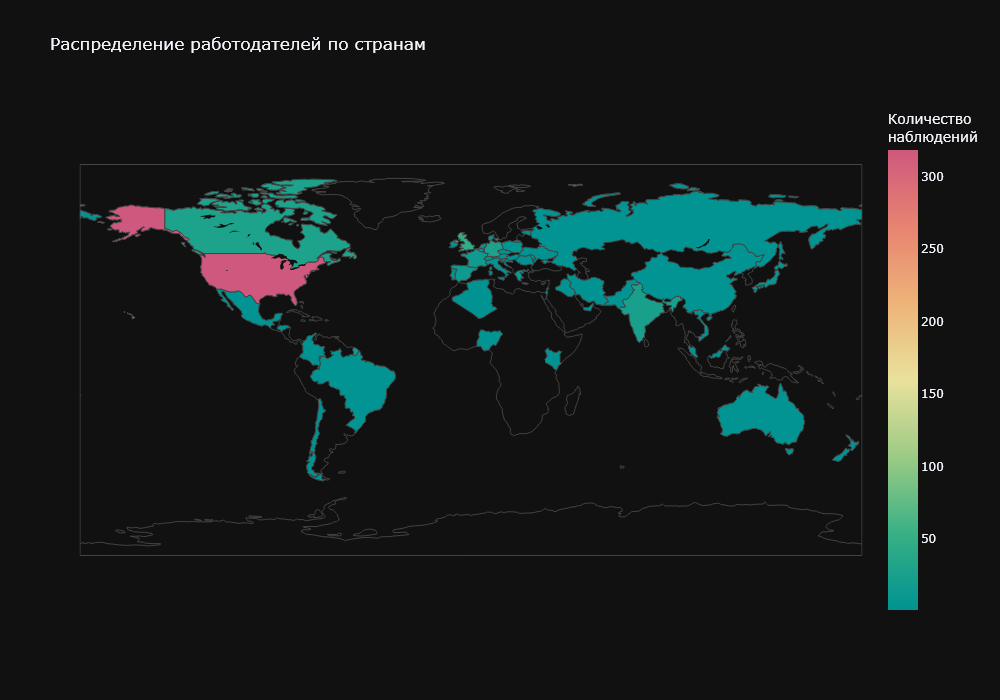

In [17]:
df['employee_residence'] = df['employee_residence'].apply(country_alpha2_to_country_name)
df['company_location'] = df['company_location'].apply(country_alpha2_to_country_name)

grouped_emp_res = df.groupby(by='employee_residence',as_index=False)['company_location'].count().rename(columns={'company_location': 'count'})
grouped_comp_loc = df.groupby(by='company_location',as_index=False)['employee_residence'].count().rename(columns={'employee_residence': 'count'})

px.choropleth(
    grouped_emp_res,
    locationmode='country names',
    locations='employee_residence',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1000,
    height=700,
    title='Распределение соискателей по странам'
).update_layout(coloraxis_colorbar_title='Количество<br>наблюдений').show()

px.choropleth(
    grouped_comp_loc,
    locationmode='country names',
    locations='company_location',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1000,
    height=700,
    title='Распределение работодателей по странам'
).update_layout(coloraxis_colorbar_title='Количество<br>наблюдений').show()

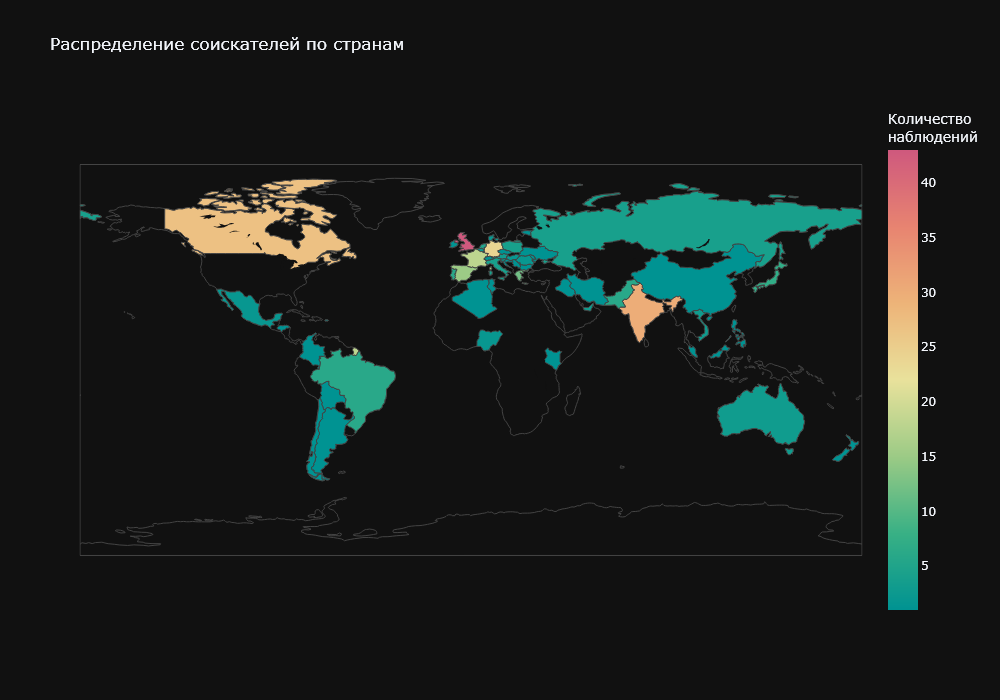

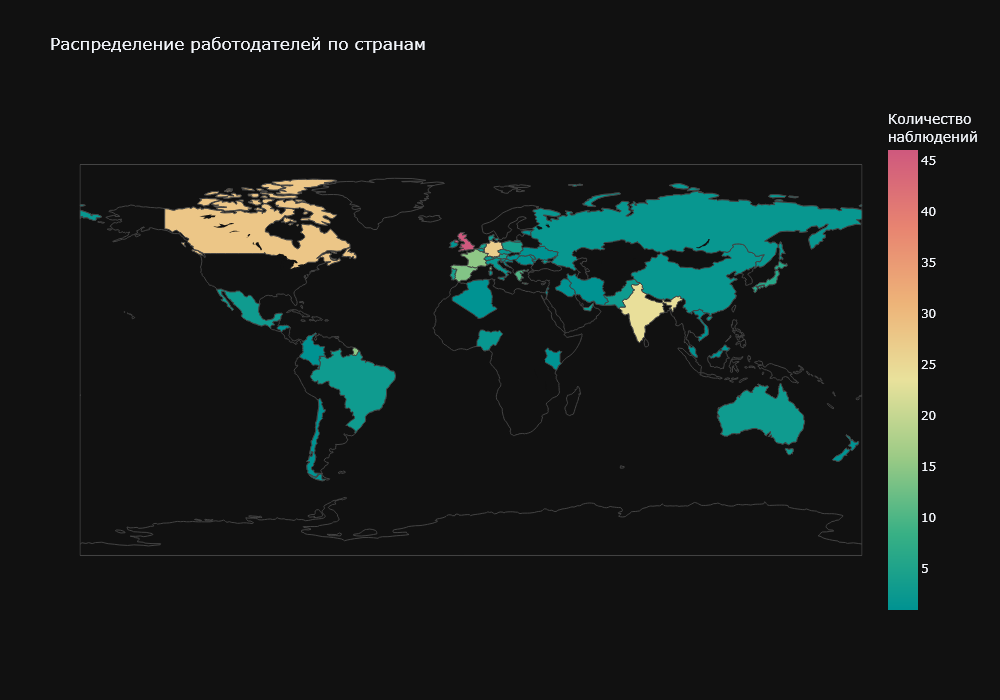

In [18]:
grouped_emp_res = grouped_emp_res.drop(index=55, axis=0)
grouped_comp_loc = grouped_comp_loc.drop(index=48, axis=0)

px.choropleth(
    grouped_emp_res,
    locationmode='country names',
    locations='employee_residence',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1000,
    height=700,
    title='Распределение соискателей по странам'
).update_layout(coloraxis_colorbar_title='Количество<br>наблюдений').show()

px.choropleth(
    grouped_comp_loc,
    locationmode='country names',
    locations='company_location',
    color='count',
    color_continuous_scale=px.colors.diverging.Temps,
    width=1000,
    height=700,
    title='Распределение работодателей по странам'
).update_layout(coloraxis_colorbar_title='Количество<br>наблюдений').show()

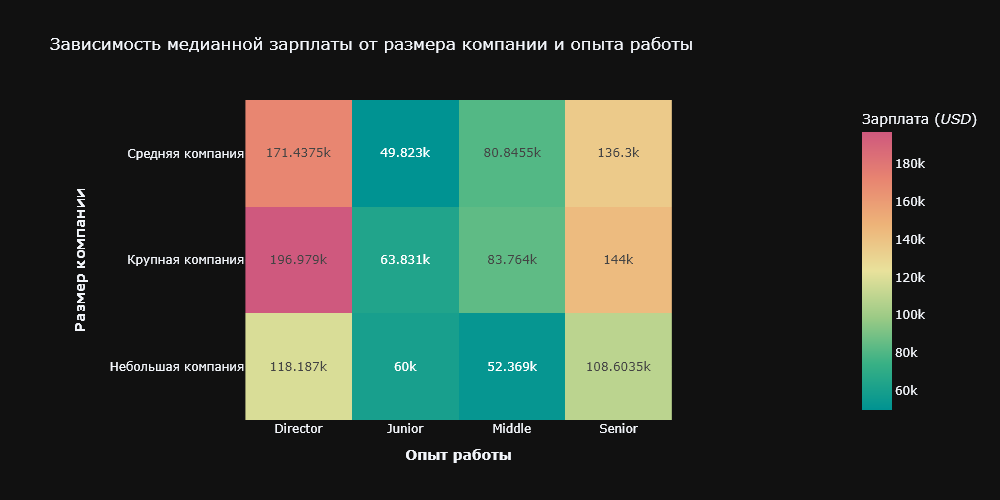

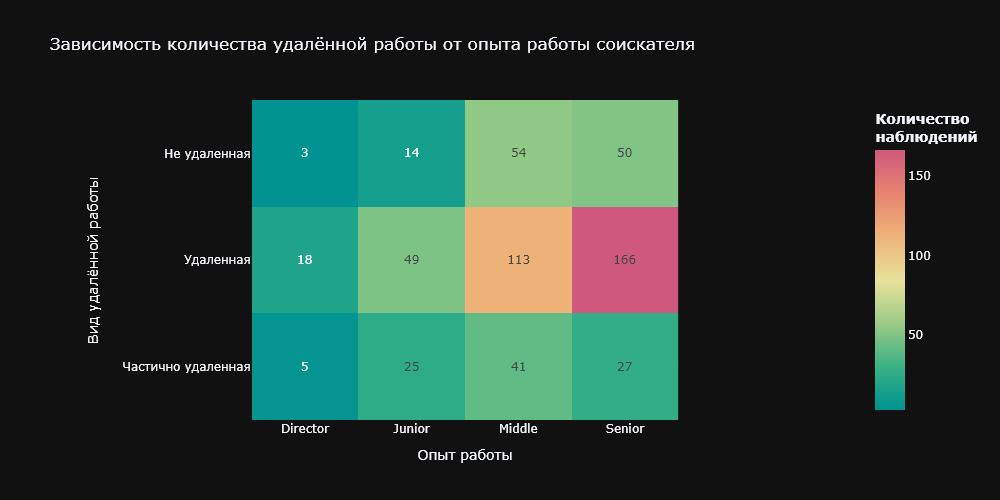

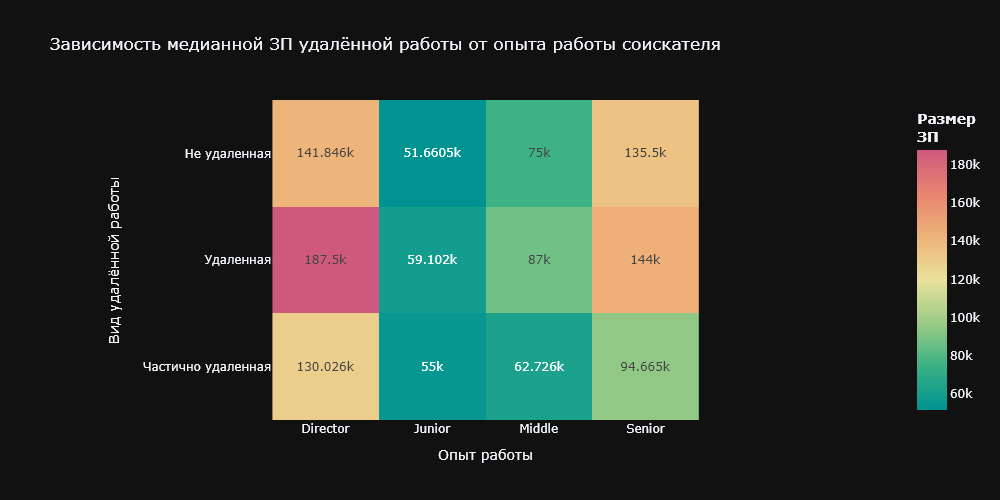

In [19]:
salary_pivot = df.pivot_table(
    values='salary_in_usd', 
    columns='experience_level',
    index='company_size',
    aggfunc='median'
)
fig_1 = px.imshow(
    salary_pivot,
    text_auto=True,
    color_continuous_scale=px.colors.diverging.Temps,
    title='Зависимость медианной зарплаты от размера компании и опыта работы',
    width=1000,
    height=500,
    labels={
        'y': '<b>Размер компании</b>',
        'x': '<b>Опыт работы</b>'
    },
).update_layout(coloraxis_colorbar_title='Зарплата (<i>USD</i>)')

exp_remote_pivot = df.pivot_table(
    index='remote_ratio',
    columns='experience_level',
    values='job_title',
    aggfunc='count'
)
fig_2 = px.imshow(
    exp_remote_pivot,
    width=1000,
    height=500,
    color_continuous_scale=px.colors.diverging.Temps,
    text_auto=True,
    labels={
        'x': 'Опыт работы',
        'y': 'Вид удалённой работы'
    },
    title='Зависимость количества удалённой работы от опыта работы соискателя'
).update_yaxes(
    tickmode='array',
    tickvals=[0, 50, 100]
).update_layout(
    coloraxis_colorbar_title='<b>Количество<br>наблюдений</b>'
).update_yaxes(tickmode='array', tickvals=['Не удаленная', 'Частично удаленная', 'Удаленная'])

salary_remote_pivot = df.pivot_table(
    index='remote_ratio',
    columns='experience_level',
    values='salary_in_usd',
    aggfunc='median'
)
fig_3 = px.imshow(
    salary_remote_pivot,
    width=1000,
    height=500,
    color_continuous_scale=px.colors.diverging.Temps,
    text_auto=True,
    labels={
        'x': 'Опыт работы',
        'y': 'Вид удалённой работы'
    },
    title='Зависимость медианной ЗП удалённой работы от опыта работы соискателя'
).update_yaxes(
    tickmode='array',
    tickvals=[0, 50, 100]
).update_layout(
    coloraxis_colorbar_title='<b>Размер<br>ЗП</b>'
).update_yaxes(tickmode='array', tickvals=['Не удаленная', 'Частично удаленная', 'Удаленная'])

display(fig_1),
display(fig_2),
display(fig_3)

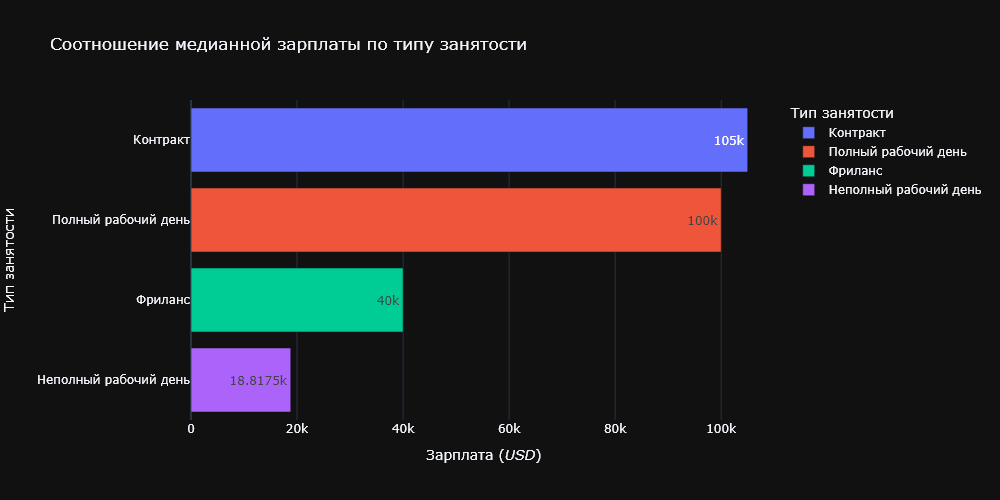

In [20]:
employment_type_salary = df.groupby(by='employment_type', as_index=False)['salary_in_usd'].median().sort_values(by='salary_in_usd', ascending=False)
px.bar(
    employment_type_salary,
    x='salary_in_usd',
    y='employment_type',
    title='Соотношение медианной зарплаты по типу занятости',
    color='employment_type',
    text_auto=True,
    height=500,
    width=1000,
    labels={
        'employment_type' : 'Тип занятости',
        'salary_in_usd' : 'Зарплата (<i>USD</i>)'
    }
)

Из графиков выше можно сделать первоначальные выводы:

* Признак зарплаты имеет логнормальное распределение
* В датасете преобладают данные о специалистах уровня *SE (Senior-level/Expert)* и *MI (Mid-level/Intermediate)*
* Почти во всех наблюдениях (96%) тип трудоустройства указан как *FT (полный рабочий день)*
* Топ-3 самых популярных профессии в датасете:
    1. *Data Scientist*
    2. *Data Engineer*
    3. *Data Analyst*
* Большая часть соискателей и работодателей находятся на территории США
* Самая высокая медианная зарплата *(196k USD)* у людей с опытом работы *EX (Executive-level/Director)* в крупных компаниях *(более 250 чел.)*
* Самая низкая медианная зарплата *(49k USD)* у людей с опытом работы *EN (Entry-level/Junior)* в средних компаниях *(от 50 до 250 чел.)*
* 60% вакансий - полностью удалённая работа
* Половина компаний из датасета имеет средний размер *(от 50 до 250 чел.)*
* Самая высокооплачиваемая должность - *Data Analytics Lead*
* На зарплату больше всего влияет в первую очередь опыт соискателя, во вторую - размер компании
* Больше всего на полностью удалённой работе находятся специалисты уровня *SE*

## Ключевые вопросы HR-агенства

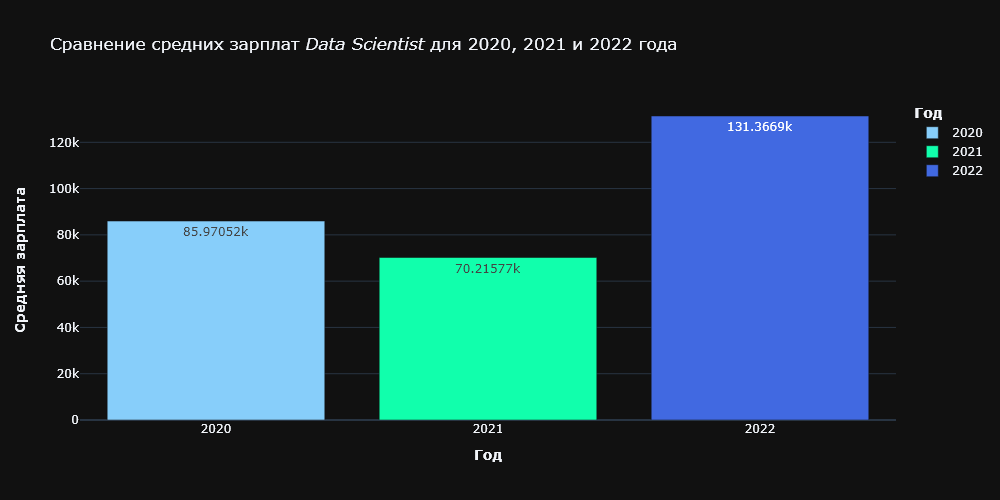

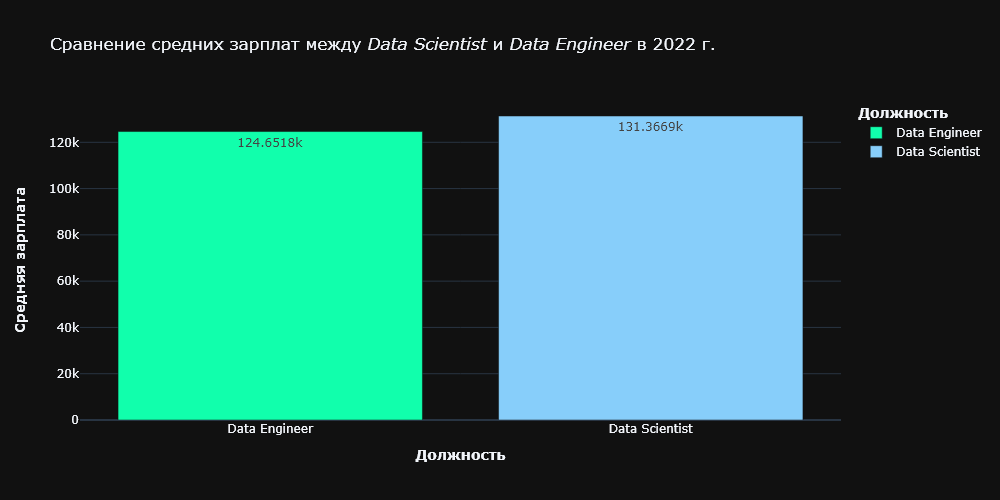

In [21]:
ds_jobs = df[df['job_title'] == 'Data Scientist']
grouped_ds_jobs = ds_jobs.groupby(by='work_year', as_index=False)['salary_in_usd'].mean()
grouped_ds_jobs['work_year'] = grouped_ds_jobs['work_year'].astype(object)

fig_1 = px.bar(
    grouped_ds_jobs,
    x='work_year',
    y='salary_in_usd',
    title='Сравнение средних зарплат <i>Data Scientist</i> для 2020, 2021 и 2022 года',
    width=1000,
    height=500,
    color='work_year',
    color_discrete_sequence=['#87CEFA', '#11ffac', '#4169E1'],
    text_auto=True,
    labels={'work_year': '<b>Год</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
).update_xaxes(
    tickmode='linear',
    tick0=2020, 
    dtick=1
)

ds_de_jobs_2022 = df[(df['job_title'].isin(['Data Scientist', 'Data Engineer'])) & (df['work_year'] == 2022)]
grouped_ds_de_jobs = ds_de_jobs_2022.groupby(by='job_title', as_index=False)['salary_in_usd'].mean()

fig_2 = px.bar(
    grouped_ds_de_jobs,
    y='salary_in_usd',
    x='job_title',
    color='job_title',
    width=1000,
    height=500,
    title='Сравнение средних зарплат между <i>Data Scientist</i> и <i>Data Engineer</i> в 2022 г.',
    text_auto=True,
    labels={'salary_in_usd': '<b>Средняя зарплата</b>', 'job_title': '<b>Должность</b>'},
    color_discrete_sequence=['#11ffac', '#87CEFA']
)

display(fig_1),
display(fig_2)

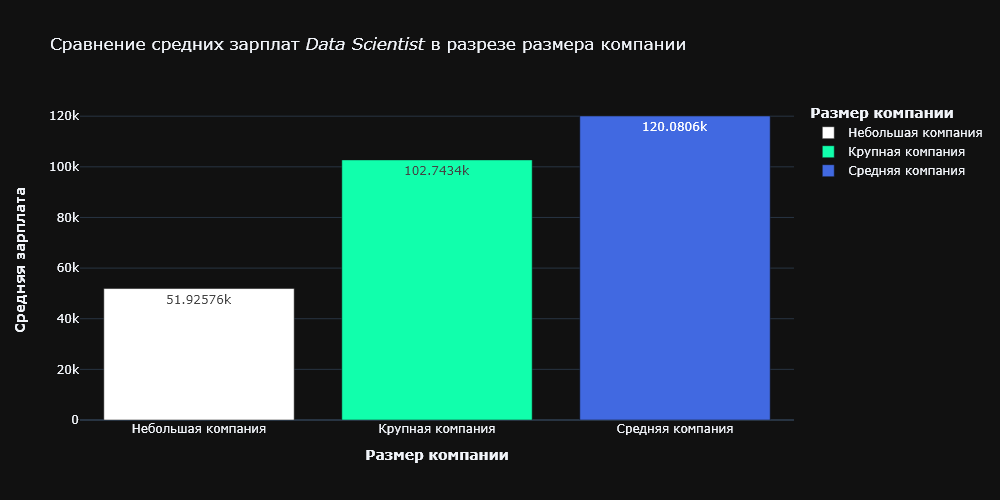

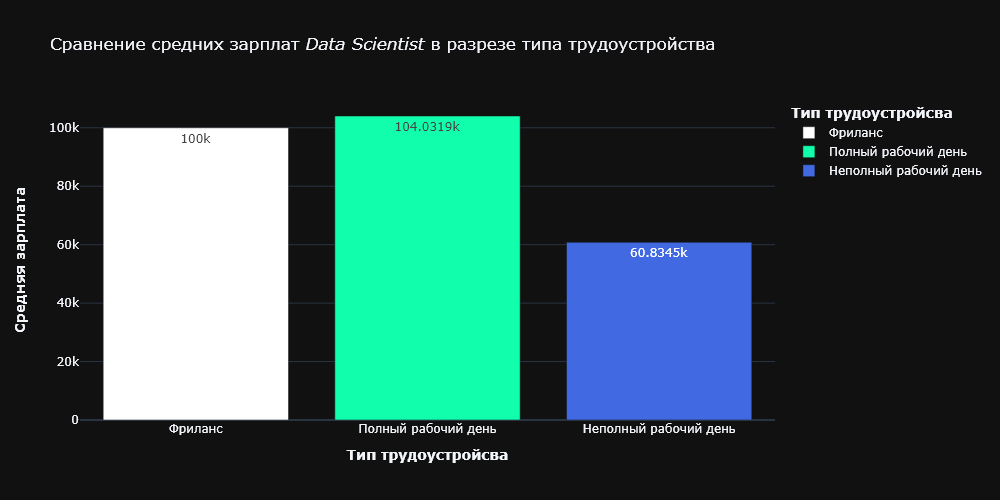

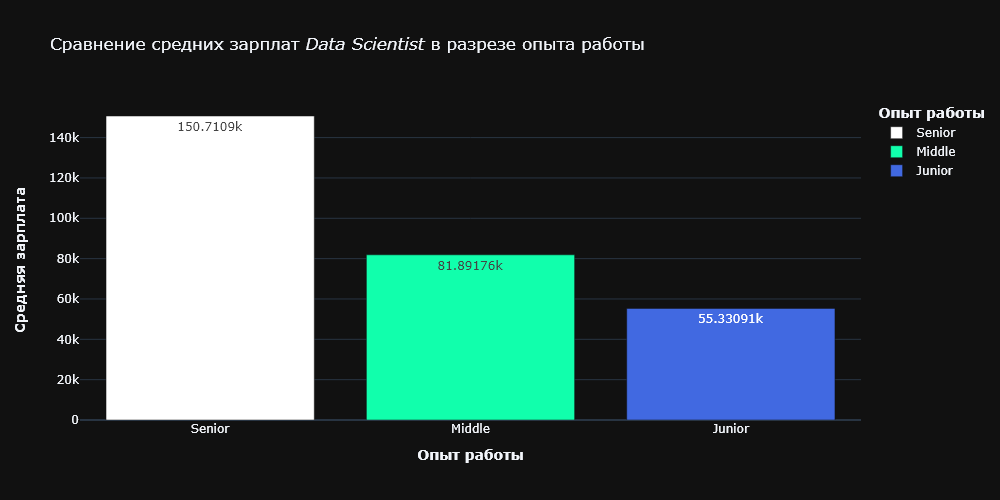

In [22]:
grouped_ds_size = ds_jobs.groupby(by='company_size', as_index=False)['salary_in_usd'].mean().sort_values(by='company_size', ascending=False)
fig_1 = px.bar(
    grouped_ds_size,
    x='company_size',
    y='salary_in_usd',
    color='company_size',
    width=1000,
    height=500,
    title='Сравнение средних зарплат <i>Data Scientist</i> в разрезе размера компании',
    text_auto=True,
    color_discrete_sequence=['#FFFFFF', '#11ffac', '#4169E1'],
    labels={'company_size': '<b>Размер компании</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
).update_xaxes(tickmode='array', tickvals=['Небольшая компания', 'Cредняя компания', 'Крупная компания'])

grouped_ds_employment_type = ds_jobs.groupby(by='employment_type', as_index=False)['salary_in_usd'].mean().sort_values(by='employment_type', ascending=False)
fig_2 = px.bar(
    grouped_ds_employment_type,
    x='employment_type',
    y='salary_in_usd',
    color='employment_type',
    width=1000,
    height=500,
    title='Сравнение средних зарплат <i>Data Scientist</i> в разрезе типа трудоустройства',
    text_auto=True,
    color_discrete_sequence=['#FFFFFF', '#11ffac', '#4169E1'],
    labels={'employment_type': '<b>Тип трудоустройсва</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
)

grouped_ds_experience_level = ds_jobs.groupby(by='experience_level', as_index=False)['salary_in_usd'].mean().sort_values(by='experience_level', ascending=False)
fig_3 = px.bar(
    grouped_ds_experience_level,
    x='experience_level',
    y='salary_in_usd',
    color='experience_level',
    width=1000,
    height=500,
    title='Сравнение средних зарплат <i>Data Scientist</i> в разрезе опыта работы',
    text_auto=True,
    color_discrete_sequence=['#FFFFFF', '#11ffac', '#4169E1'],
    labels={'experience_level': '<b>Опыт работы</b>', 'salary_in_usd': '<b>Средняя зарплата</b>'}
)

display(fig_1),
display(fig_2),
display(fig_3)

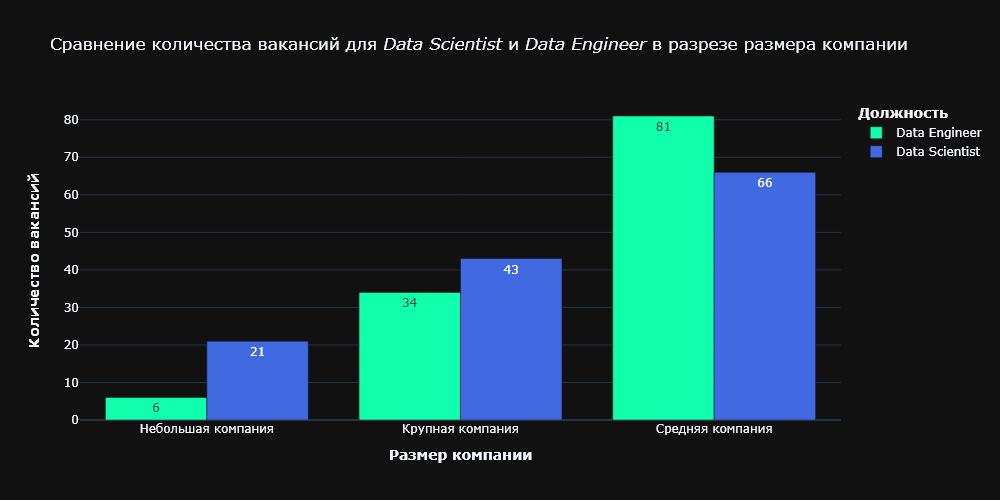

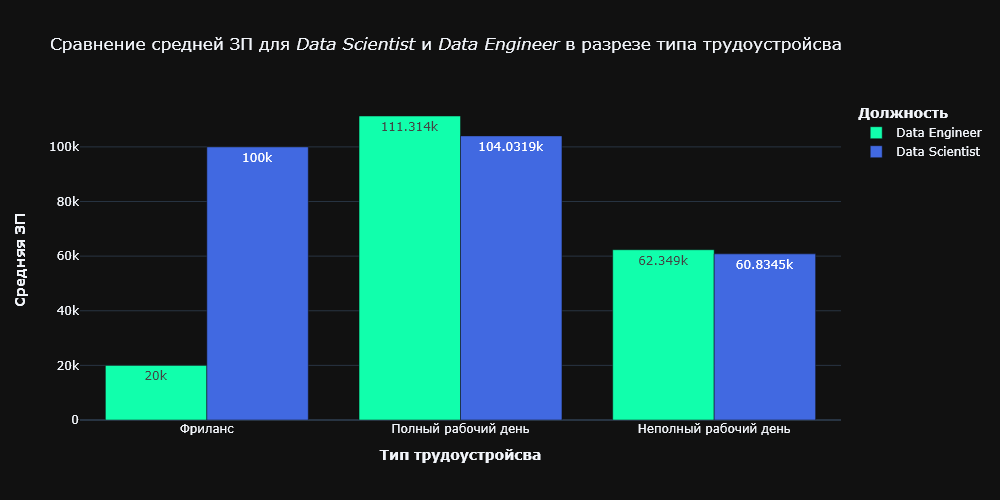

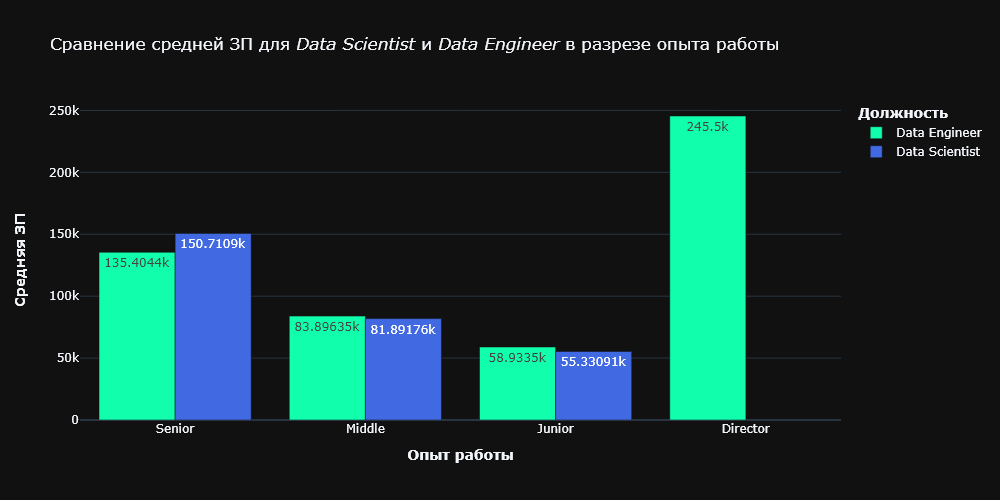

In [23]:
ds_de_jobs = df[(df['job_title'].isin(['Data Scientist', 'Data Engineer']))]
grouped_ds_de_size = ds_de_jobs.groupby(by=['company_size', 'job_title'],as_index=False)['salary_in_usd'].count().rename(columns={'salary_in_usd': 'count'}).sort_values(by='company_size',ascending=False)
fig_1 = px.bar(
    grouped_ds_de_size,
    x='company_size',
    y='count',
    color='job_title',
    barmode='group',
    text_auto=True,
    title='Сравнение количества вакансий для <i>Data Scientist</i> и <i>Data Engineer</i> в разрезе размера компании',
    width=1000,
    height=500,
    labels={
        'count': '<b>Количество вакансий</b>',
        'job_title': '<b>Должность</b>',
        'company_size': '<b>Размер компании</b>'
    },
    color_discrete_sequence=['#11ffac', '#4169E1']
)

grouped_ds__de_employment_type = ds_de_jobs.groupby(by=['employment_type', 'job_title'],as_index=False)['salary_in_usd'].mean().sort_values(by='employment_type',ascending=False)
fig_2 = px.bar(
    grouped_ds__de_employment_type,
    x='employment_type',
    y='salary_in_usd',
    color='job_title',
    barmode='group',
    text_auto=True,
    title='Сравнение средней ЗП для <i>Data Scientist</i> и <i>Data Engineer</i> в разрезе типа трудоустройсва',
    width=1000,
    height=500,
    labels={
        'salary_in_usd': '<b>Средняя ЗП</b>',
        'job_title': '<b>Должность</b>',
        'employment_type': '<b>Тип трудоустройсва</b>'
    },
    color_discrete_sequence=['#11ffac', '#4169E1']
)

grouped_ds__de_experience_level = ds_de_jobs.groupby(by=['experience_level', 'job_title'],as_index=False)['salary_in_usd'].mean().sort_values(by='experience_level',ascending=False)
fig_3 = px.bar(
    grouped_ds__de_experience_level,
    x='experience_level',
    y='salary_in_usd',
    color='job_title',
    barmode='group',
    text_auto=True,
    title='Сравнение средней ЗП для <i>Data Scientist</i> и <i>Data Engineer</i> в разрезе опыта работы',
    width=1000,
    height=500,
    labels={
        'salary_in_usd': '<b>Средняя ЗП</b>',
        'job_title': '<b>Должность</b>',
        'experience_level': '<b>Опыт работы</b>'
    },
    color_discrete_sequence=['#11ffac', '#4169E1']
)

display(fig_1),
display(fig_2),
display(fig_3)

Из графиков, относящихся к ключевым вопросам, можно отметить следующее:

* В 2022-ом году средняя зарплата *Data Scientist* стала намного выше, чем в 2020 и 2021 годах
* Особой разницы между зарплатами *Data Engineer* и *Data Scientist* не видно. Необходимо провести статистический тест, чтобы ответить на этот вопрос, т.к. по графику такая разница может быть просто погрешностью
* В компаниях малого размера (S) платят намного меньше, чем в компаниях среднего (M) и крупного (L) размера. Причем наибольшая средняя зарплата для *Data Scientist* приходится именно на компании размера M
* В компаниях малого размера очень мало вакансий для обеих должностей *(Data Engineer и Data Scientist)*. Больше всего в таких сотрудниках нуждаются компании среднего размера. В крупных компаниях чаще нужен именно *Data Scientist*, а не *Data Engineer*

## Статистический анализ данных

### Сравнение зарплат специалистов Data Scientist в зависимости от года

* **Нулевая гипотеза**: нет разницы между медианами зарплаты для Data Scientist в зависимости от года <br>
    $$H_{0} : Me_{2020} = Me_{2021} = Me_{2022}$$
* **Альтернативная гипотеза**: есть разница между медианами зарплаты для Data Scientist в зависимости от года <br>
    $$H_{1} : Me_{2020} \neq  Me_{2021} \neq Me_{2022}$$

In [24]:
# Напишем функции для проверки гипотез, зададим начальный уровень alpha
alpha = 0.05

def test_normal(*samples):
    
    for i, sample in enumerate(samples, start=1):
        _, p_value = stats.shapiro(sample)
        print(f'Для выборки №{i} {p_value=:.3f}')
        if p_value <= alpha:
            print('Распределение отлично от нормального\n')
        else:
            print('Распределение является нормальным\n')


def test_hypothesis(p_value):
    
    print(f'{p_value=:.3f}')
    if p_value <= alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('У нас нет причин отвергать нулевую гипотезу')

In [25]:
ds_2020, ds_2021, ds_2022 = [
    df[(df['job_title'] == 'Data Scientist') & (df['work_year'] == year)]['salary_in_usd'].values 
    for year in df['work_year'].unique()
]
test_normal(ds_2020, ds_2021, ds_2022)

Для выборки №1 p_value=0.000
Распределение отлично от нормального

Для выборки №2 p_value=0.107
Распределение является нормальным

Для выборки №3 p_value=0.676
Распределение является нормальным



* Хотя бы одна из выборок не является нормально распределенной - **непараметрический тест**
* 3 независимые группы - **Критерий Краскела - Уоллиса**

In [26]:
_, p_value = stats.kruskal(ds_2020, ds_2021, ds_2022)
test_hypothesis(p_value)

p_value=0.000
Отвергаем нулевую гипотезу


**Вывод**: существует разница в медианах зарплаты *Data Scientist* для каждого года. Если ссылаться на построенный график, то можно с уверенностью сказать, что в 2022 году зарплата стала больше, чем в предыдущих.

### Сравнение средних зарплат Data Scientist и Data Engineer в 2022 году

* **Нулевая гипотеза**: средняя зарплата Data Scientist ($\mu_{1}$) меньше или равна, чем средняя зарплата Data Engineer ($\mu_{2}$).<br>
    $$H_{0}:\mu_{1} \le \mu_{2}$$
* **Альтернативная гипотеза**: средняя зарплата Data Scientist больше, чем средняя зарплата Data Engineer<br>
    $$H_{1}:\mu_{1} \gt  \mu_{2}$$

In [27]:
ds_salary_2022, de_salary_2022 = [
    df[(df['job_title'] == job) & (df['work_year'] == 2022)]['salary_in_usd'].values
    for job in ['Data Scientist', 'Data Engineer']
]
test_normal(ds_salary_2022, de_salary_2022)

Для выборки №1 p_value=0.676
Распределение является нормальным

Для выборки №2 p_value=0.007
Распределение отлично от нормального



* Распределение отлично от нормального - **непараметрический тест**
* 2 независимые группы - **U-критерий Манна - Уитни**

In [28]:
_, p_value = stats.mannwhitneyu(ds_salary_2022, de_salary_2022, alternative='greater')
test_hypothesis(p_value)

p_value=0.160
У нас нет причин отвергать нулевую гипотезу


**Вывод**: средняя зарплата *Data Scientist* меньше или равна средней зарплате *Data Engineer*. Та разница, что видна на графике, не является статистически значимой.

### Сравнение зарплаты специалистов Data Scientist в зависимости от размера компании

* **Нулевая гипотеза**: нет разницы в медианной зарплате ($Me$) в компаниях разных размеров ($S$-маленькая, $M$-средняя, $l$-крупная)<br>
    $$H_{0}: Me_{S}=Me_{M}=Me_{L}$$
* **Альтернативная гипотеза**: существует разница в медианной зарплате в компаниях разных размеров<br>
    $$H_{1}: Me_{S}\ne Me_{M}\ne Me_{L}$$

In [29]:
ds_S, ds_M, ds_L = [
   ds_jobs[ds_jobs['company_size'] == job]['salary_in_usd'].values
   for job in ['Небольшая компания', 'Cредняя компания', 'Крупная компания']
]
test_normal(ds_S, ds_M, ds_L)

Для выборки №1 p_value=0.189
Распределение является нормальным

Для выборки №2 p_value=0.897
Распределение является нормальным

Для выборки №3 p_value=0.000
Распределение отлично от нормального



* Хотя бы в одной группе распределение отлично от нормального - **непараметрический тест**
* 3 независимые группы - **Критерий Краскела - Уоллиса**

In [30]:
_, p_value = stats.kruskal(ds_S, ds_M, ds_L)
test_hypothesis(p_value)

p_value=0.000
Отвергаем нулевую гипотезу


**Вывод**: зарплата **Data Scientist** зависит от размера компании.

### Сравнение количества вакансий для Data Scientist и Data Engineer в разрезе размера компании

* **Нулевая гипотеза**: количество вакансий не зависит от размера компании и должности
* **Альтернативная гипотеза**: количество вакансий зависит от размера компании и должности

In [31]:
ds_de_crosstab = pd.crosstab(index=ds_de_jobs['company_size'], columns=ds_de_jobs['job_title'])
ds_de_crosstab

job_title,Data Engineer,Data Scientist
company_size,,
Cредняя компания,81,66
Крупная компания,34,43
Небольшая компания,6,21


Сравниваем связь между двумя категориальными признаками (``job_title`` и ``company_size``) - критерий $X^{2}$

In [32]:
_, p_value, _, _ = stats.chi2_contingency(ds_de_crosstab)
test_hypothesis(p_value)

p_value=0.005
Отвергаем нулевую гипотезу


**Вывод**: количество вакансий *Data Scientist* и *Data Engineer* зависит от размера компании.

### Сравнение зарплаты Data Scientist со медианной зарплатой из предоставленного датасета

* **Нулевая гипотеза**: медианная зарплата Data Scientist ($Me_{DS}$) равна медианной зарплате из датасета ($Me_{data}$)<br>
    $$H_{0}:Me_{DS}=Me_{data}$$
* **Альтернативная гипотеза**: медианная зарплата Data Scientist не равна медианной зарплаты из датасета<br>
    $$H_{1}:Me_{DS}\ne Me_{data}$$

In [33]:
ds_salary = df[df['job_title'] == 'Data Scientist']['salary_in_usd']
total_salary_median = df['salary_in_usd'].median()
print(f'Медианная зарплата всего датасета: {total_salary_median}\n')
# Проверим распределение зарплат DS на нормальность
test_normal(ds_salary)

Медианная зарплата всего датасета: 100000.0

Для выборки №1 p_value=0.000
Распределение отлично от нормального



* Распределение отлично от нормального - **непараметрический тест**
* 1 группа - **критерий знаков для одной выборки**

In [34]:
_, p_value = sign_test(samp=ds_salary, mu0=total_salary_median)
test_hypothesis(p_value)

p_value=0.858
У нас нет причин отвергать нулевую гипотезу


**Вывод**: медианная зарплата специалистов *Data Scientist* совпадает с медианной зарплатой из всего предоставленного датасета.

### Дополнительное исследование

#### Сравнение зарплаты специалистов начального уровня (EN) в зависимости от размера компании

Будем сравнивать размеры *S* (малые компании) и *L* (большие компании)

* **Нулевая гипотеза**: медианная зарплата ($Me$) в больших компаниях (L) меньше или равна медианной зарплате в малых компаниях (S) <br>
    $$H_{0}:Me_{L} \le   Me_{S}$$
* **Альтернативная гипотеза**: медианная зарплата в больших компаниях больше медианной зарплаты в малых компаниях (S) <br>
    $$H_{1}:Me_{L} \gt  Me_{S}$$

In [35]:
salary_EN_L, salary_EN_S = [
    df[
        (df['company_size'] == size)
        & (df['experience_level'] == 'Junior')
    ]['salary_in_usd']
    for size in ['Крупная компания', 'Небольшая компания']
]
test_normal(salary_EN_L, salary_EN_S)

Для выборки №1 p_value=0.000
Распределение отлично от нормального

Для выборки №2 p_value=0.174
Распределение является нормальным



* Хотя бы одно из распределений отлично от нормального - **непараметрический тест**
* 2 независимые выборки - **U-критерий Манна - Уитни**

In [36]:
_, p_value = stats.mannwhitneyu(salary_EN_L, salary_EN_S, alternative='greater')
test_hypothesis(p_value)

p_value=0.312
У нас нет причин отвергать нулевую гипотезу


**Вывод**: медианная зарплата специалистов среди всех должностей начального уровня не зависит от размера компании.

### Существует ли зависимость между опытом работы сотрудника и наличием удалённой работы?

* **Нулевая гипотеза**: отсутствует взаимосвязь между количеством удалённой работы и опытом работы
* **Альтернативная гипотеза**: существует взаимосвязь между количеством удалённой работы и опытом работы

Сравниваем зависимость между двумя категориальными векторами (``experience_level`` и ``remote_ratio``) - критерий $X^2$

In [37]:
exp_remote_crosstab = pd.crosstab(columns=df['experience_level'], index=df['remote_ratio'])
exp_remote_crosstab

experience_level,Director,Junior,Middle,Senior
remote_ratio,,,,
Не удаленная,3,14,54,50
Удаленная,18,49,113,166
Частично удаленная,5,25,41,27


In [38]:
p_value = stats.chi2_contingency(exp_remote_crosstab)[1]
test_hypothesis(p_value)

p_value=0.002
Отвергаем нулевую гипотезу


**Вывод**: существует взаимосвязь между количеством удалённой работы и опытом работы.

## Вывод по проделанной работе

1. На зарплату специалистов *Data Scientist* больше всего влияют следующие факторы: опыт работы и размер компании.

2. Ключевые вопросы HR-агенства:

    * Наблюдается ежегодный рост зарплат у специалистов *Data Scientist*.
    * Нет статистически значимой разницы между зарплатами *Data Scientist* и *Data Engineer* в 2022 г.
    * Зарплата *Data Scientist* зависит от размера компании. Наибольшее среднее значение зарплаты принадлежит компаниями среднего размера (M) и равно 120k USD.
    * Количество должностей *Data Scientist* и *Data Engineer* зависит от размера компании. Больше всего в данных сотрудниках нуждаюстся компании среднего (M) размера, меньше всего - малого размера (S)

3. Дополнительные исследования:

    * Зарплата специалистов среди всех должностей начального уровня (EN) не зависит от размера компании.
    * Cуществует взаимосвязь между количеством удалённой работы и опытом работы. У специалистов уровня (SE) больше всего вакансий с полностью удалённой работой.